In [1]:
import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym
from IPython.display import clear_output
import numpy as np
from collections import defaultdict
import wandb
from tqdm.auto import tqdm

/Users/hugoderohanwillner/anaconda3/envs/MSc_RL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def test_policy(policy=None, fps=1):
    '''
        Visually evaluate a policy, fallback to random action
    '''

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()[0]

    # iterate
    while True:

        # Select next action
        if policy is None:
            # Sample random action if no policy is given
            action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
        else:
            # Check if state is in policy
            if obs not in policy:
                # If not, sample random action
                action = env.action_space.sample()
            else:
                # Use policy to determine the next action
                action = policy[obs]

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        clear_output(wait=True)
        sys.stdout.write(env.render())
        print('Action: ', action)
        print('Observation: ', obs)
        print('Reward: ', reward)
        time.sleep(1/fps) # FPS
        

        # If player is dead break
        if done:
            break

    env.close()


In [5]:
# Generate episode data

def generate_episode_from_Q(env, Q, epsilon, nA, max_ep_length):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()[0] # fix new version
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, info, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done or len(episode)>max_ep_length:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    # Each action has an associated probability
    # The best action has a probability of 1 - epsilon + (epsilon / nA) - the rest have a probability of epsilon / nA
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [3]:
# MC Control Training
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.999, eps_min=0.00, wandb_tracking=False, wandb_sweep = False, max_ep_length = 500):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    ep_rewards = []
    # Login to wandb
    if wandb_tracking:
        wandb.login()
        wandb.init(
            project="flappy-flappy_mc_sweep",
            config = {"alpha": alpha, "gamma": gamma, "eps_start": eps_start, "eps_decay": eps_decay, "eps_min": eps_min}
        )

    # loop over episodes
    for i_episode in tqdm(range(1, num_episodes+1)):
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA, max_ep_length)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)

        ep_reward = np.sum([x[2] for x in episode])
        ep_rewards.append(ep_reward)
        # Log to wandb
        if wandb_tracking or wandb_sweep:
            wandb.log({"reward": ep_reward})

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())

    # Get the mean ep reward
    mean_ep_reward = np.mean(ep_rewards)

    return policy, Q, mean_ep_reward

In [41]:
policy

{(13, 1): 1,
 (12, 1): 0,
 (11, 0): 1,
 (10, 1): 1,
 (9, 0): 0,
 (8, 1): 1,
 (7, 0): 1,
 (6, 1): 1,
 (5, 0): 1,
 (4, 1): 1,
 (3, 4): 1,
 (2, 3): 1,
 (1, 2): 1,
 (13, -5): 1,
 (12, -6): 1,
 (11, -5): 0,
 (10, -6): 1,
 (9, -7): 0,
 (8, -8): 1,
 (7, -7): 0,
 (6, -4): 1,
 (5, -5): 1,
 (4, -4): 1,
 (3, -1): 0,
 (2, -2): 0,
 (1, -3): 0,
 (13, -2): 0,
 (12, -3): 1,
 (11, -2): 1,
 (13, -4): 1,
 (12, -5): 1,
 (11, -6): 1,
 (10, -7): 1,
 (9, -6): 1,
 (8, -7): 1,
 (7, -8): 1,
 (6, -9): 1,
 (5, -10): 1,
 (4, -11): 1,
 (3, -11): 0,
 (2, -11): 1,
 (1, -10): 1,
 (13, 2): 0,
 (12, 2): 1,
 (11, 4): 1,
 (10, 3): 1,
 (9, 2): 1,
 (6, -1): 1,
 (4, -1): 1,
 (3, -2): 1,
 (2, -3): 0,
 (1, -2): 0,
 (9, 4): 1,
 (8, 3): 0,
 (7, 4): 1,
 (6, 3): 0,
 (5, 2): 0,
 (4, 3): 0,
 (3, 2): 1,
 (1, 6): 1,
 (13, 4): 1,
 (12, 3): 1,
 (11, 2): 0,
 (9, 6): 1,
 (8, 5): 1,
 (5, 4): 1,
 (4, 7): 1,
 (13, 3): 0,
 (11, 1): 0,
 (10, 2): 1,
 (9, 5): 1,
 (8, 10): 1,
 (7, 9): 1,
 (6, 10): 1,
 (7, -9): 1,
 (6, -8): 1,
 (4, 0): 1,
 (10, -2

In [5]:
# obtain the estimated optimal policy and action-value function
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

policy, Q, mean_ep_reward = mc_control(env, 100, 0.02, wandb_tracking=False)

100%|██████████| 100/100 [00:00<00:00, 2170.09it/s]


In [6]:
mean_ep_reward

11.75

In [60]:
# save the policy to the current directory
np.save('MC_policy_500_max.npy', policy)

In [61]:
# Load the policy
new_policy = np.load('MC_policy_500_max.npy', allow_pickle=True).item()

# Test the policy
test_policy(policy=new_policy,fps=20)

Text Flappy Bird!
Score: 103
----------------------
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |  @             ]
[   |                ]
[                    ]
[                    ]
[             |      ]
[             |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=7,dy=-2)
Action:  1
Observation:  (7, -2)
Reward:  1


KeyboardInterrupt: 

In [18]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items()) # use the max value of the action-value function since it is the optimal policy


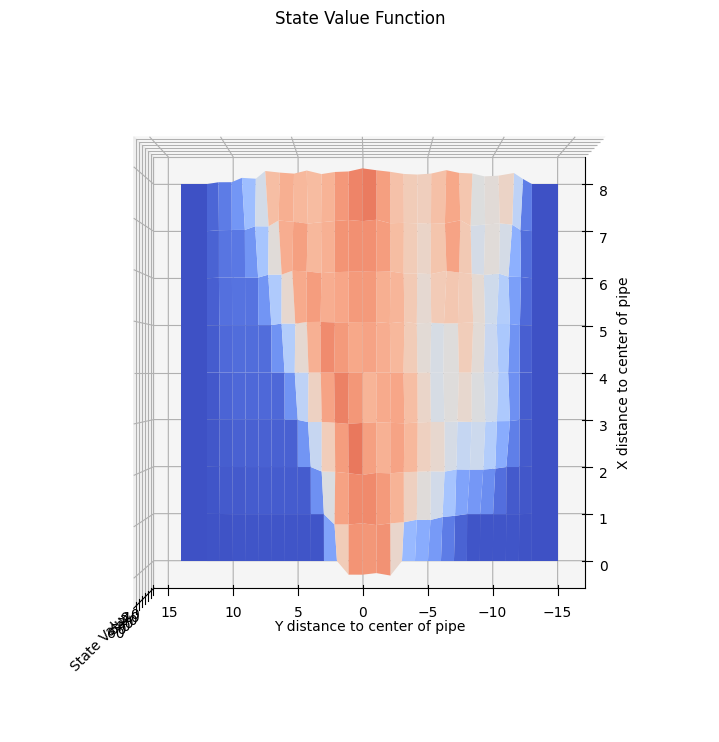

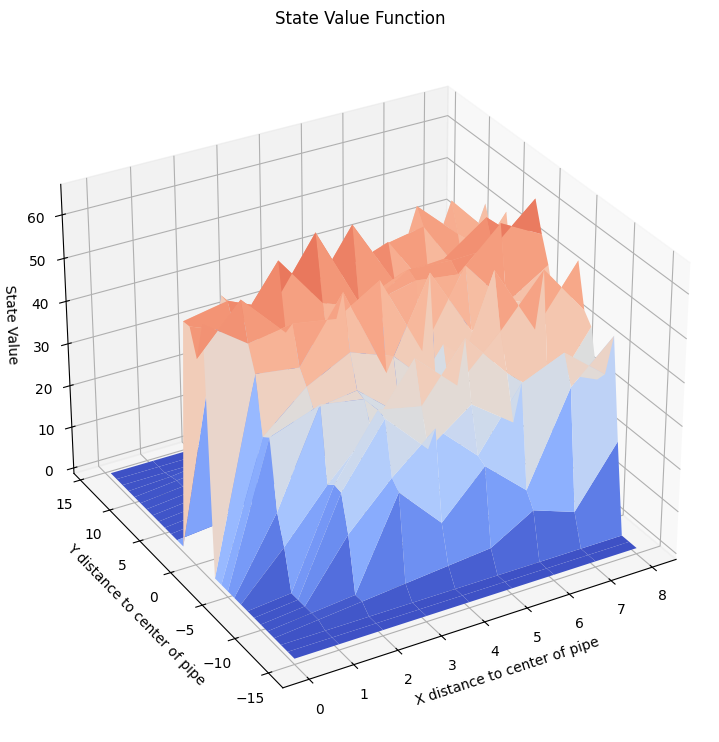

In [32]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_flappy_values(V):

    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax,top_view=False):
        x_range = np.arange(0, 9)
        y_range = np.arange(-15, 15)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=70)
        ax.set_xlabel('X distance to center of pipe')
        ax.set_ylabel('Y distance to center of pipe')
        ax.set_zlabel('State Value')
        if top_view:
            ax.view_init(90,180)
        else:
            ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('State Value Function')
    get_figure(ax, top_view=True)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('State Value Function')
    get_figure(ax, top_view=False)

    plt.show()

plot_flappy_values(V)

In [2]:
# SARSA LAMBDA TRAINING
def sarsa_lambda_train(env, num_episodes, alpha, lambda_, gamma=1.0, eps_start=1.0, eps_decay=.9999, eps_min=0.05, wandb_tracking=False, wandb_sweep=False,  max_ep_length = 500):
    nA = env.action_space.n # number of actions
    # Init Q Table
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    ep_rewards = []
    # Login to wandb
    if wandb_tracking:
        wandb.login()
        wandb.init(
            project="flappy-bird_rl",
            config = {"sarsa_lambda": True, "lambda": lambda_,"alpha": alpha, "gamma": gamma, "eps_start": eps_start, "eps_decay": eps_decay, "eps_min": eps_min}
        )

    # loop over episodes
    for i_episode in tqdm(range(1, num_episodes+1)):
        
        # Reset traces! 
        # https://stackoverflow.com/questions/29904270/eligibility-trace-reinitialization-between-episodes-in-sarsa-lambda-implementati
        E = defaultdict(lambda: np.zeros(nA))
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # reset the state
        state = env.reset()[0] # fix new version
        ep_reward = 0
        # Get the first action using eps greedy policy
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # Go through an episode
        while True:
            # take a step in the environement 
            next_state, reward, done, info, _ = env.step(action)
            # Eps-greedy next_action
            next_action = np.random.choice(np.arange(nA), p=get_probs(Q[next_state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()

            # Calculate TD error
            delta = reward + gamma*Q[next_state][next_action] - Q[state][action]
            # Increase the trace weight for this state action pair
            E[state][action] += 1
            # Loop through all s,a
            # TODO: only loop through items where traces are not zero?
            for state, _ in Q.items():
                for action in range(nA):
                    # Update all Qs related to the current Q using traces
                    Q[state][action] += alpha*delta*E[state][action]
                    # Decay the traces at each step
                    # TODO: could do this on the whole matrix outside the loop?
                    E[state][action] *= gamma*lambda_
            # Setup for next loop
            state = next_state
            action = next_action
            ep_reward += reward
            # Using ep reward as a break condition
            if done or ep_reward>max_ep_length:
                break
        
        # Add the reward to the list
        ep_rewards.append(ep_reward)
        # Log to wandb
        if wandb_tracking or wandb_sweep:
            wandb.log({"reward": ep_reward})

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())

    # Get the mean ep reward
    mean_ep_reward = np.mean(ep_rewards)

    return policy, Q, mean_ep_reward

In [15]:
# obtain the estimated optimal policy and action-value function
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

sara_policy, Q, mean_ep_reward = sarsa_lambda_train(env, 5000, 0.02,0.5,wandb_tracking=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▄▂▁▁▃▁▁▂▂▁▂▁▃█▂▁█▃
reward,214


100%|██████████| 5000/5000 [00:25<00:00, 194.08it/s]


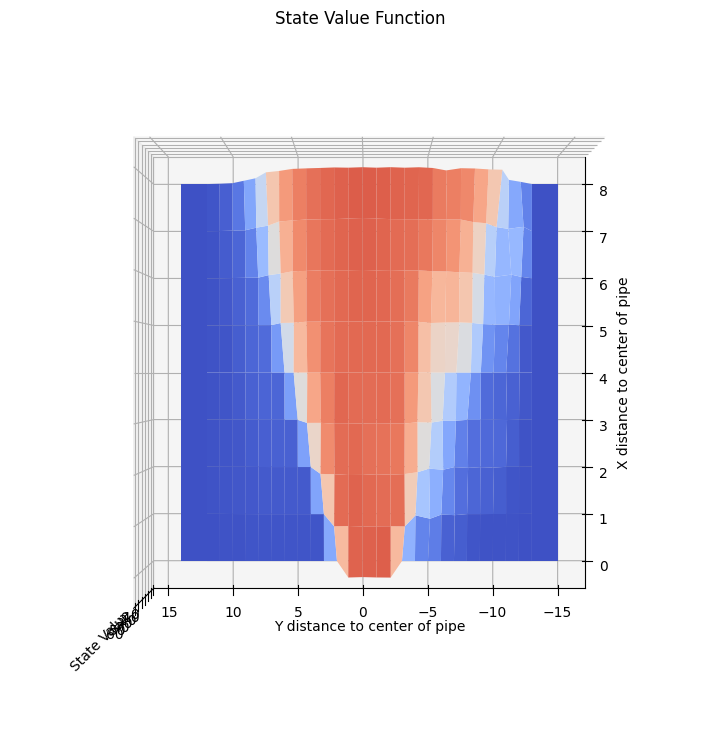

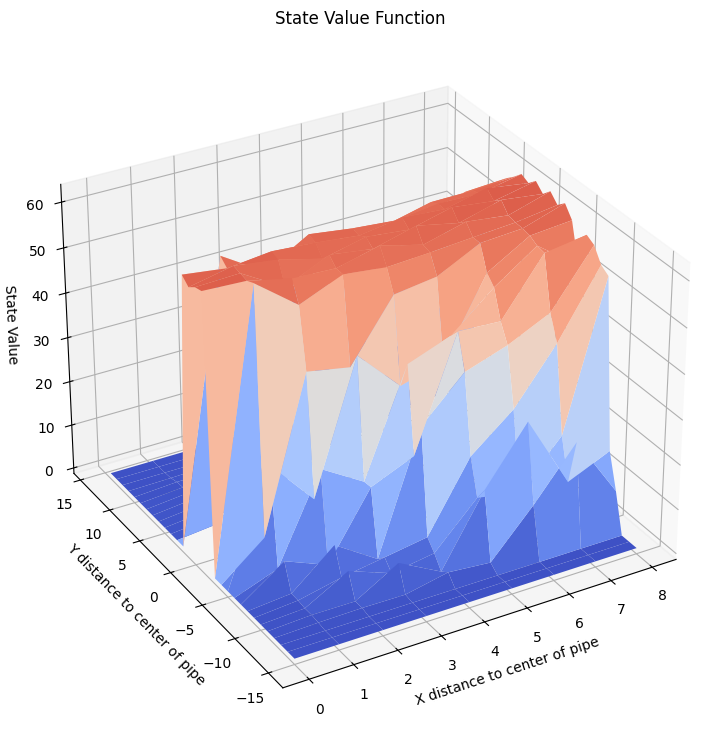

wandb: Network error (ConnectionError), entering retry loop.


In [49]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items()) # use the max value of the action-value function since it is the optimal policy

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_flappy_values(V):

    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax,top_view=False):
        x_range = np.arange(0, 9)
        y_range = np.arange(-15, 15)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=70)
        ax.set_xlabel('X distance to center of pipe')
        ax.set_ylabel('Y distance to center of pipe')
        ax.set_zlabel('State Value')
        if top_view:
            ax.view_init(90,180)
        else:
            ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('State Value Function')
    get_figure(ax, top_view=True)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('State Value Function')
    get_figure(ax, top_view=False)

    plt.show()

plot_flappy_values(V)

In [8]:
# MC PARAM SWEEP

wandb.login()

# 1: Define objective/training function
def objective(config):
    # Hardcoded:
    num_episodes = 8000
    eps_min = 0
    max_ep_length = 500
    gamma = 1
    wandb_run_tracking = False
    wandb_sweep = True

    # From config
    alpha = config.alpha
    eps_start = config.eps_start
    eps_decay = config.eps_decay

    # Setup environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

    # Run training
    policy, Q, mean_ep_reward = mc_control(env, num_episodes, alpha, gamma=gamma, eps_start=eps_start, eps_decay=eps_decay, eps_min=eps_min, wandb_tracking=wandb_run_tracking, wandb_sweep=wandb_sweep, max_ep_length = max_ep_length)

    return mean_ep_reward

def main():
    wandb.init(project="flappy_mc_sweep_v3")
    mean_ep_reward = objective(wandb.config)
    wandb.log({"mean_ep_reward": mean_ep_reward})

# 2: Define the search space
sweep_configuration = {
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "mean_ep_reward"},
    "parameters": {
        "alpha": {"max": 0.1, "min": 0.001},
        "eps_start": {"values": [1, 0.75, 0.5]},
        "eps_decay": {"values": [0.999, 0.99, 0.9]},
    },
}

# 3: Start the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project="flappy_mc_sweep_v3")

wandb.agent(sweep_id, function=main, count=10)

Create sweep with ID: whool4g0
Sweep URL: https://wandb.ai/hugoderohanwillner/flappy_mc_sweep_v3/sweeps/whool4g0


wandb: Agent Starting Run: l82xr3kw with config:
wandb: 	alpha: 0.0956034315761124
wandb: 	eps_decay: 0.99
wandb: 	eps_start: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [01:57<00:00, 68.35it/s] 


mean_ep_reward,▁
reward,▁▂▁▆▆██▆▃█▇█▄▄███████▄██▇███▁██▆▄▅████▅█
mean_ep_reward,403.13862
reward,501


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8uh1ik4t with config:
wandb: 	alpha: 0.006968590623289223
wandb: 	eps_decay: 0.9
wandb: 	eps_start: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:04<00:00, 1815.97it/s]


mean_ep_reward,▁
reward,▄▄▅▄▃▅▁▁▁▃▂▂▇▃▁█▅▇▁▁▃▄▆▁▄▁▃▆▁▄▂▃▁▄▄▃▁▁▆▃
mean_ep_reward,23.26625
reward,18


wandb: Agent Starting Run: wwmwgcca with config:
wandb: 	alpha: 0.0619707344672119
wandb: 	eps_decay: 0.99
wandb: 	eps_start: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:23<00:00, 344.95it/s]


mean_ep_reward,▁
reward,▁▂▄▃▂█▅▃▁▂▇▆▂▄▂▇▁▇▁▁▃▃▃▇▁▁▃▃█▁▄▁▁▃▃▇▁▁▁▃
mean_ep_reward,108.17925
reward,98


wandb: Agent Starting Run: jow53sf3 with config:
wandb: 	alpha: 0.010719626829176192
wandb: 	eps_decay: 0.999
wandb: 	eps_start: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:45<00:00, 176.48it/s] 


mean_ep_reward,▁
reward,▁▁▁▁▁▁▂▁▁▁▁▂▁▁▃▂▂██▁▆▆█▃█▆▃▃▁▅█▃█▄▇▆▃▆▄▃
mean_ep_reward,175.22162
reward,247


wandb: Agent Starting Run: gkwp6bj8 with config:
wandb: 	alpha: 0.09288006738709956
wandb: 	eps_decay: 0.9
wandb: 	eps_start: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:02<00:00, 3593.90it/s]


mean_ep_reward,▁
reward,▁▃▁▃█▃██▄███▃▃██▃███▃▁████▃██▁▃██▄███▃▃█
mean_ep_reward,10.94688
reward,13


wandb: Agent Starting Run: wojgmhrw with config:
wandb: 	alpha: 0.0940657943348629
wandb: 	eps_decay: 0.999
wandb: 	eps_start: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [01:09<00:00, 115.51it/s] 


mean_ep_reward,▁
reward,▁▁▁▁▁▁▁▁▄▁▁▂▁█▂▄▁▃▄▇▁▇▆▁▅██▄█▄██▄██████▆
mean_ep_reward,243.37625
reward,405


wandb: Agent Starting Run: 8eqe98ew with config:
wandb: 	alpha: 0.03748388234126337
wandb: 	eps_decay: 0.9
wandb: 	eps_start: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:03<00:00, 2219.96it/s]


mean_ep_reward,▁
reward,▃▁▂▂▅▅▁▁▁▁▅▅▁▂▁▅▁█▁▁▅▅▁▅▁▅▁▁▃▅▂▅▁▂▁▁▅▅▅▂
mean_ep_reward,18.46337
reward,13


wandb: Agent Starting Run: pswrda6w with config:
wandb: 	alpha: 0.09153831971079662
wandb: 	eps_decay: 0.99
wandb: 	eps_start: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:11<00:00, 666.91it/s]


mean_ep_reward,▁
reward,▁▁▁▄▂▃▃▁▁▁▅▂▁▁▃▅▄▂▂▁█▁▄▄▂▂▁▂▃▂▁▁▂▄▁▃▂▃▄▁
mean_ep_reward,59.17612
reward,13


wandb: Agent Starting Run: zg2qy2q7 with config:
wandb: 	alpha: 0.08787717536070289
wandb: 	eps_decay: 0.99
wandb: 	eps_start: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [01:53<00:00, 70.56it/s] 


mean_ep_reward,▁
reward,▁▃▄█▄▃█▅▅████▂▄▇█▄█▆██▄███▇██▇██▁▄██▂███
mean_ep_reward,390.21
reward,501


wandb: Agent Starting Run: 0vpjdhkr with config:
wandb: 	alpha: 0.0510334274415497
wandb: 	eps_decay: 0.99
wandb: 	eps_start: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:09<00:00, 854.90it/s]


mean_ep_reward,▁
reward,▁▁▂▄▁▁▃▁▂▄▁▃▄▂▁▂▃▁▂▂▄▂▂█▂▁▇▇▁▄▁▁▁▃▆▃▂▄▃▁
mean_ep_reward,50.56525
reward,15


In [7]:
# SARSA PARAM SWEEP

wandb.login()

# 1: Define objective/training function
def objective(config):
    # Hardcoded:
    num_episodes = 8000
    eps_min = 0
    max_ep_length = 500
    gamma = 1
    wandb_run_tracking = False
    wandb_sweep = True

    # From config
    alpha = config.alpha
    eps_start = config.eps_start
    eps_decay = config.eps_decay
    lambda_ = config.lambda_

    # Setup environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

    # Run training
    policy, Q, mean_ep_reward = sarsa_lambda_train(env, num_episodes, alpha, lambda_, gamma=gamma, eps_start=eps_start, eps_decay=eps_decay, eps_min=eps_min, wandb_tracking=wandb_run_tracking, wandb_sweep=wandb_sweep, max_ep_length = max_ep_length)

    return mean_ep_reward

def main():
    wandb.init(project="flappy_mc_sweep_v3")
    mean_ep_reward = objective(wandb.config)
    wandb.log({"mean_ep_reward": mean_ep_reward})

# 2: Define the search space
sweep_configuration = {
    "method": "bayes",
    "metric": {"goal": "maximize", "name": "mean_ep_reward"},
    "parameters": {
        "alpha": {"max": 0.1, "min": 0.001},
        "eps_start": {"values": [1, 0.75, 0.5]},
        "eps_decay": {"values": [0.999, 0.99, 0.9]},
        "lambda_": {"max": 1.0, "min": 0.01},
    },
}

# 3: Start the sweep
sweep_id = wandb.sweep(sweep=sweep_configuration, project="flappy_mc_sweep_v3")

wandb.agent(sweep_id, function=main, count=10)

Create sweep with ID: fgbzgdlm
Sweep URL: https://wandb.ai/hugoderohanwillner/flappy_mc_sweep_v3/sweeps/fgbzgdlm


wandb: Agent Starting Run: pkql3nuj with config:
wandb: 	alpha: 0.025949463198413732
wandb: 	eps_decay: 0.9999
wandb: 	eps_start: 1
wandb: 	lambda_: 0.22189798481823475
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:48<00:00, 166.59it/s]


mean_ep_reward,▁
reward,▁▂▂▂▁▁▂▂▂▂▂▁▂▁▂▁▂▂▃▂▃▆▃▁▂▃▃▂▂▃▂▂▅▄▁▂█▃▃▄
mean_ep_reward,16.86575
reward,23


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q3z4k4rj with config:
wandb: 	alpha: 0.007070462872956522
wandb: 	eps_decay: 0.9999
wandb: 	eps_start: 0.75
wandb: 	lambda_: 0.06662223174187791
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:31<00:00, 253.04it/s]


mean_ep_reward,▁
reward,▃▁▁▃▂▂▁▃▃▃▂▃▃▃▃▂▁▃▃▄▃▂▆▁▂▃▃█▄▃▁▁▂▁▁▆▄▂▁▆
mean_ep_reward,11.63275
reward,7


wandb: Agent Starting Run: w5s8svrw with config:
wandb: 	alpha: 0.047973171497586654
wandb: 	eps_decay: 0.9999
wandb: 	eps_start: 1
wandb: 	lambda_: 0.12711569374996573
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:47<00:00, 169.05it/s]


mean_ep_reward,▁
reward,▃▂▁▁▂▃▃▃▁▄▄▂▃▃▂▄▂▃▁▄▂▄▂▂▂▂▁▃▃▄▄▄▆▁▆█▄▆▄▁
mean_ep_reward,17.588
reward,13


wandb: Agent Starting Run: u1wxlemv with config:
wandb: 	alpha: 0.04817523371103546
wandb: 	eps_decay: 0.9999
wandb: 	eps_start: 1
wandb: 	lambda_: 0.1798882345818887
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:48<00:00, 165.30it/s]


mean_ep_reward,▁
reward,▂▂▂▂▃▁▂▂▃▂▂▄▁▂█▂▂▁▂▂▁▅▁▂▁▁▁▂▂▄▅▄▃▄▃▅▂▇▇▄
mean_ep_reward,17.50787
reward,23


wandb: Agent Starting Run: qchiolga with config:
wandb: 	alpha: 0.054304751897024814
wandb: 	eps_decay: 0.9999
wandb: 	eps_start: 1
wandb: 	lambda_: 0.13137401801324564
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:46<00:00, 170.71it/s]


mean_ep_reward,▁
reward,▃▁▂▂▂▁▂▂▁▂▂▃▂▃█▂▄▃▂▄▂▂▂▁▂▃▂▇▃▂▂▄▂▂▁▄▃▃▃▃
mean_ep_reward,17.65175
reward,13


wandb: Agent Starting Run: q6fenf6n with config:
wandb: 	alpha: 0.04722888650828668
wandb: 	eps_decay: 0.9999
wandb: 	eps_start: 1
wandb: 	lambda_: 0.10810767977291054
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:46<00:00, 172.22it/s]


mean_ep_reward,▁
reward,▁▂▁▃▃▁▂▂▂▆▂▂▁▂▂▂▁▁▄▂▁▂▂▂▁▂▂▁▃▇▃▄▆▂▃▂▂█▂▃
mean_ep_reward,17.46175
reward,26


wandb: Agent Starting Run: ei644kkc with config:
wandb: 	alpha: 0.049763025290651894
wandb: 	eps_decay: 0.999
wandb: 	eps_start: 1
wandb: 	lambda_: 0.1741492355001743
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [01:26<00:00, 92.23it/s] 


mean_ep_reward,▁
reward,▂▂▁▂▂▁▂▂▂▂▁▂▃▂▃▃▄▅▂▄▅▃▃▄▂▅▅▄▇▂▆▄▃▃▄▃▄▄█▄
mean_ep_reward,33.41712
reward,28


wandb: Agent Starting Run: ps131ctk with config:
wandb: 	alpha: 0.05041435831179095
wandb: 	eps_decay: 0.99
wandb: 	eps_start: 1
wandb: 	lambda_: 0.2315236598205092
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:42<00:00, 188.51it/s]


mean_ep_reward,▁
reward,▃▂▅▄▁▃▃▃▄▄▃▃▂▆▄▃▄▂▃▃▃▁▄▂▂▇▄▂▆▁▄▃▇▃▄▂▃▃█▆
mean_ep_reward,18.03237
reward,11


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxzk4bz4 with config:
wandb: 	alpha: 0.04550273376284127
wandb: 	eps_decay: 0.99
wandb: 	eps_start: 1
wandb: 	lambda_: 0.2775917677046802
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:38<00:00, 209.93it/s]


mean_ep_reward,▁
reward,▃▃▃▂▃█▃▂▃▃▃▃▃▆▃▆▃▃▆▆█▃▃▂▂▃▂▃▆█▆█▃▃▃▆▃▁▃▂
mean_ep_reward,16.70962
reward,23


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ie5jyg5j with config:
wandb: 	alpha: 0.0472423454204413
wandb: 	eps_decay: 0.999
wandb: 	eps_start: 1
wandb: 	lambda_: 0.06181320873124114
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


100%|██████████| 8000/8000 [00:56<00:00, 142.15it/s]


mean_ep_reward,▁
reward,▁▂▁▂▂▁▂▂▃▁▂▁▃▃▂▁▂▂▃▁▆▄▂▃▄▃▃▁▂▂█▄▂▃▂▁▂▆▄▇
mean_ep_reward,21.25163
reward,10
